In [28]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sqlite3
import sqlalchemy

SqliteNames=["NC_EnergySystem2023_C.sqlite","NC_EnergySystem2023_M.sqlite","NC_EnergySystem2023_A.sqlite"]
SqliteNames=["NC_EnergySystem2023.sqlite"]
OutputSqlTables={"Output_CapacityByPeriodAndTech":"",
                 "Output_Costs":"",
                 "Output_Curtailment":"",
                 "Output_Duals":"",
                 "Output_Emissions":"",
                 "Output_Objective":"",
                 "Output_VFlow_In":"",
                 "Output_VFlow_Out":"",
                 "Output_V_Capacity":""}


# Read sqlite files

In [29]:
DeterministicPath="DeterministicFiles/"


for i in range(len(SqliteNames)):
    SqliteName=SqliteNames[i]
    for table_name in list(OutputSqlTables.keys()):
        engine = sqlalchemy.create_engine("sqlite:///%s" % DeterministicPath+SqliteName, execution_options={"sqlite_raw_colnames": True})
        df = pd.read_sql_table(table_name, engine)
        if i==0:
            OutputSqlTables[table_name]=df
        else:
            OutputSqlTables[table_name]=pd.concat([OutputSqlTables[table_name],df],ignore_index=True)



# Define group of technologies we may want to plot

In [30]:
TechAtGroups={"Biomass":["AB_ST_EXISTING","BLQ_ST_EXISTING","OBG_IC_EXISTING","WDS_ST_EXISTING",
                        "WH_ST_EXISTING","LFG_GT_EXISTING","LFG_IC_EXISTING","BIOMASS_NEW"],

                "Biomass_CCS":["BIOMASS_CC90_NEW"],

                # "Coal":["BIT_ST_EXISTING","COAL_NEW","COAL_95CC_NEW","COAL_99CC_NEW"],

                # "Coal_CCS":["COAL_95CC_NEW","COAL_99CC_NEW"],

                "NaturalGas":["NG_CC_EXISTING","NG_GT_EXISTING","NG_ST_EXISTING",
                            "NG_F-FRAME_CT_NEW","NG_F-FRAME_CC_NEW","NG_H-FRAME_CC_NEW"],

                "NaturalGas_CCS":["NG_F-FRAME_CC_95CC_NEW","NG_H-FRAME_CC_95CC_NEW","NG_F-FRAME_CC_97CC_NEW",
                            "NG_H-FRAME_CC_97CC_NEW"],

                "Nuclear":["NUCLEAR-AP1000_NEW","NUCLEAR-SMR_NEW","NUC_ST_EXISTING"],

                # "Petrol":["DFO_CC_EXISTING","DFO_GT_EXISTING","DFO_IC_EXISTING"],

                "Hydro":["WAT_HY_NEW","WAT_HY_EXISTING"],

                "Solar":["PV-COMMERCIAL_NEW","PV-RESIDENTIAL_NEW","PV-UTILITY_NEW","SUN_PV_EXISTING"],

                "Wind_ON/OFF":["WIND-LAND-C8_NEW","WIND-OFFSHORE-C6_NEW","WND_WT_EXISTING"],

                "Wind_ON":["WIND-LAND-C8_NEW","WND_WT_EXISTING"],

                "Wind_OFF":["WIND-OFFSHORE-C6_NEW"],

                # "CO2 Stored":["CO2_STORAGE"],

                "EnergyStorage":["BATT_2H_NEW","BATT_4H_NEW","BATT_6H_NEW",
                                "BATT_8H_NEW","MWH_BA1H_EXISTING","MWH_BA2H_EXISTING",
                                "WAT_PS_EXISTING","WAT_PS_NEW"],

                "Coal/Petrol_ALL":["DFO_CC_EXISTING","DFO_GT_EXISTING","DFO_IC_EXISTING","BIT_ST_EXISTING","COAL_NEW","COAL_95CC_NEW","COAL_99CC_NEW"],

                }

# Determine activity for each group

In [31]:
def SummarizeActivity(TechAtGroups=TechAtGroups,OutputSqlTables=OutputSqlTables):
    Output_VFlow_Out=OutputSqlTables["Output_VFlow_Out"]
    scenarios=Output_VFlow_Out["scenario"].unique()

    periods=Output_VFlow_Out["t_periods"].unique()
    periods.sort()
    periods=list(periods)+[2*periods[-1]-periods[-2]]

    PeriodName=[str(periods[i])+"-"+str(periods[i+1]) for i in range(len(periods)-1)]
    periods=periods[:-1]

    df_SummaryFlow=pd.DataFrame(columns=["scenario","period","period name","group","Activity"])

    Groups=list(TechAtGroups.keys())

    for Group in Groups:
        techs=TechAtGroups[Group]

        for scenario in scenarios:
            for period in periods:
                df=Output_VFlow_Out[(Output_VFlow_Out["scenario"]==scenario) & (Output_VFlow_Out["t_periods"]==period)]
                df=df[df["tech"].isin(techs)]
                df=df.groupby(["t_periods"]).sum().reset_index()
                df_SummaryFlow_tmp=pd.DataFrame({"scenario":scenario,"period":period,"group":Group,"Activity":df["vflow_out"],
                                                "period name":PeriodName[periods.index(period)]})
                df_SummaryFlow=pd.concat([df_SummaryFlow,df_SummaryFlow_tmp],ignore_index=True)
    return df_SummaryFlow

df_SummaryFlow=SummarizeActivity()

# Determine the emissions for each group

In [32]:
def SummarizeEmissions(TechAtGroups=TechAtGroups,OutputSqlTables=OutputSqlTables, emission_name="co2_at"):
    Output_Emissions=OutputSqlTables["Output_Emissions"]
    scenarios=Output_Emissions["scenario"].unique()

    periods=Output_Emissions["t_periods"].unique()
    periods.sort()
    periods=list(periods)+[2*periods[-1]-periods[-2]]

    PeriodName=[str(periods[i])+"-"+str(periods[i+1]) for i in range(len(periods)-1)]
    periods=periods[:-1]

    df_SummaryEmissions=pd.DataFrame(columns=["scenario","period","period name","group","Emissions"])

    Groups=list(TechAtGroups.keys())

    for Group in Groups:
        techs=TechAtGroups[Group]

        for scenario in scenarios:
            for period in periods:
                df=Output_Emissions[(Output_Emissions["scenario"]==scenario) & (Output_Emissions["t_periods"]==period) 
                                    & (Output_Emissions["emissions_comm"]==emission_name) ]
                df=df[df["tech"].isin(techs)]
                df=df.groupby(["t_periods"]).sum().reset_index()
                df_SummaryEmissions_tmp=pd.DataFrame({"scenario":scenario,"period":period,"group":Group,"Emissions":df["emissions"],
                                                "period name":PeriodName[periods.index(period)]})
                df_SummaryEmissions=pd.concat([df_SummaryEmissions,df_SummaryEmissions_tmp],ignore_index=True)
    return df_SummaryEmissions

df_SummaryEmissions=SummarizeEmissions()

# Determine the capacity for each group

In [33]:
def SummarizeCapacity(TechAtGroups=TechAtGroups,OutputSqlTables=OutputSqlTables):
    Output_CapacityByPeriodAndTech=OutputSqlTables["Output_CapacityByPeriodAndTech"]
    scenarios=Output_CapacityByPeriodAndTech["scenario"].unique()

    periods=Output_CapacityByPeriodAndTech["t_periods"].unique()
    periods.sort()
    periods=list(periods)+[2*periods[-1]-periods[-2]]

    PeriodName=[str(periods[i])+"-"+str(periods[i+1]) for i in range(len(periods)-1)]
    periods=periods[:-1]

    df_SummaryCapacity=pd.DataFrame(columns=["scenario","period","period name","group","Capacity"])

    Groups=list(TechAtGroups.keys())

    for Group in Groups:
        techs=TechAtGroups[Group]

        for scenario in scenarios:
            for period in periods:
                df=Output_CapacityByPeriodAndTech[(Output_CapacityByPeriodAndTech["scenario"]==scenario) & 
                                                  (Output_CapacityByPeriodAndTech["t_periods"]==period)]
                df=df[df["tech"].isin(techs)]
                df=df.groupby(["t_periods"]).sum().reset_index()
                df_SummaryCapacity_tmp=pd.DataFrame({"scenario":scenario,"period":period,"group":Group,"Capacity":df["capacity"],
                                                "period name":PeriodName[periods.index(period)]})
                df_SummaryCapacity=pd.concat([df_SummaryCapacity,df_SummaryCapacity_tmp],ignore_index=True)
    return df_SummaryCapacity

df_SummaryCapacity=SummarizeCapacity()

# Plot the results per period

In [34]:
X_label="Year"
Y_tabel={"Activity":"TWh/yr","Emissions":"Mt CO2","Capacity":"GW"}
Data={"Activity":df_SummaryFlow,"Emissions":df_SummaryEmissions,"Capacity":df_SummaryCapacity}

#### - modify the following parameters to plot different groups
#Place of each group in the plot
PlotGroups=[]
PlotGroups.append(["Coal/Petrol_ALL","NaturalGas", "NaturalGas_CCS"])#Line 1
PlotGroups.append(["Wind_ON/OFF","Biomass","Biomass_CCS"])#Line 2
PlotGroups.append(["Solar","Nuclear", "Hydro"])#Line 3

Iten="Activity" # "Activity" or "Emissions" or "Capacity"

In [35]:
def Plot(Iten,PlotGroups, Data=Data):
    NumXplots=len(PlotGroups)
    NumYplots=len(PlotGroups[0])
    fig, axs = plt.subplots(NumXplots, NumYplots,figsize=(8, 8))

    Scenarios=Data[Iten]["scenario"].unique()

    Colors=list(mcolors.BASE_COLORS.keys())
    x=Data[Iten]["period name"].unique()

    YMax=0
    YMin=10*6

    #Scale from kt to MT
    if Iten=="Emissions":
        Scale=1e-3
    else:
        Scale=1

    for s in range(len(Scenarios)):
        scenario=Scenarios[s]
        for i in range(NumXplots):
            for j in range(NumYplots):
                group=PlotGroups[i][j]
                y=np.zeros(len(x))

                y_tmp=Data[Iten][(Data[Iten]["scenario"]==scenario) & (Data[Iten]["group"]==group)]
                y_t=y_tmp["period name"]
                y[[np.where(x==y_t.values[i])[0][0] for i in range(len(y_t.values))]]=y_tmp[Iten].values

                axs[i, j].set_title(group)
                axs[i, j].plot(x, y*Scale, Colors[s]+"-o",alpha=0.5,label=scenario)
                axs[i, j].set_xticklabels(x, rotation=90)
                YMin=min(YMin,axs[i, j].get_ylim()[0])
                YMax=max(YMax,axs[i, j].get_ylim()[1])

    for i in range(NumXplots):
        for j in range(NumYplots):
            axs[i,j].set_ylim(YMin, YMax)

    plt.yticks(rotation = 95)
    plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

    lines_labels = [axs[0, 0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    for ax in axs.flat:
        ax.label_outer()

    fig.supxlabel("Year")
    fig.supylabel(Iten+" ("+Y_tabel[Iten]+")")
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    lines_labels = [axs[0, 0].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    fig.legend(lines, labels=labels,loc="lower center",ncol = 5, bbox_to_anchor=(0.5, -0.05),frameon=False)

    plt.savefig("Summary_Deterministic"+Iten+".png",dpi=600,bbox_inches='tight')

    return plt.show()



C:\Users\Remote\AppData\Local\Temp\ipykernel_29820\2363349126.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i, j].set_xticklabels(x, rotation=90)
C:\Users\Remote\AppData\Local\Temp\ipykernel_29820\2363349126.py:57: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(lines, labels=labels,loc="lower center",ncol = 5, bbox_to_anchor=(0.5, -0.05),frameon=False)


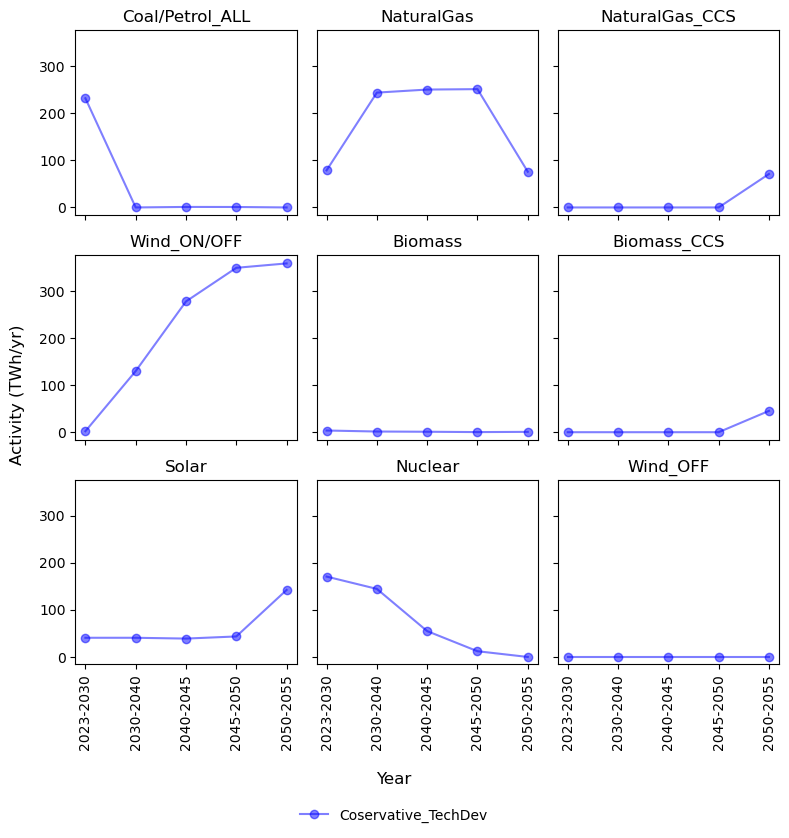

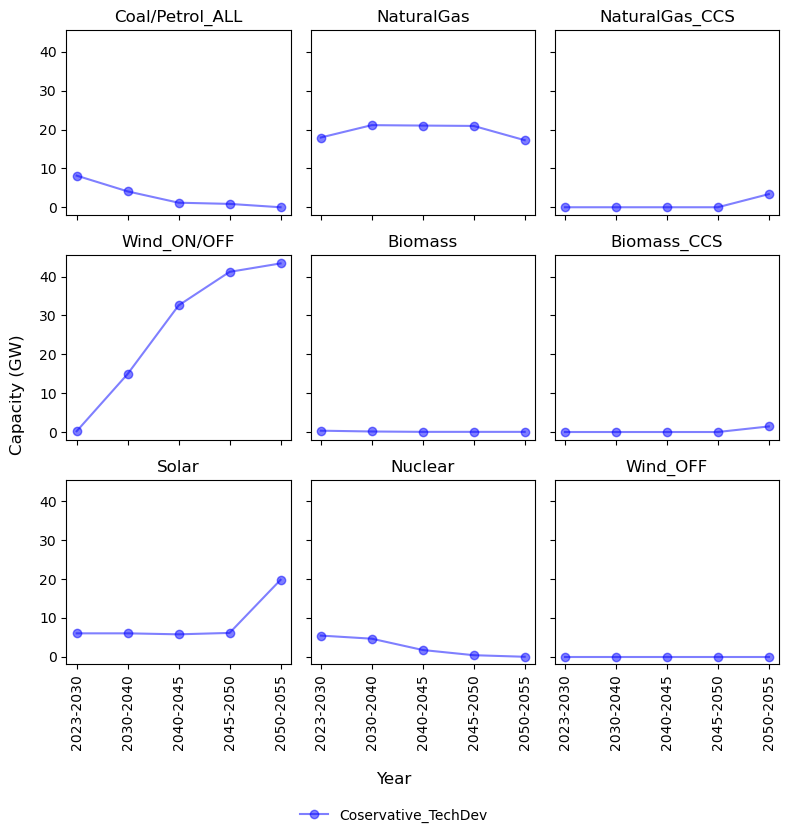

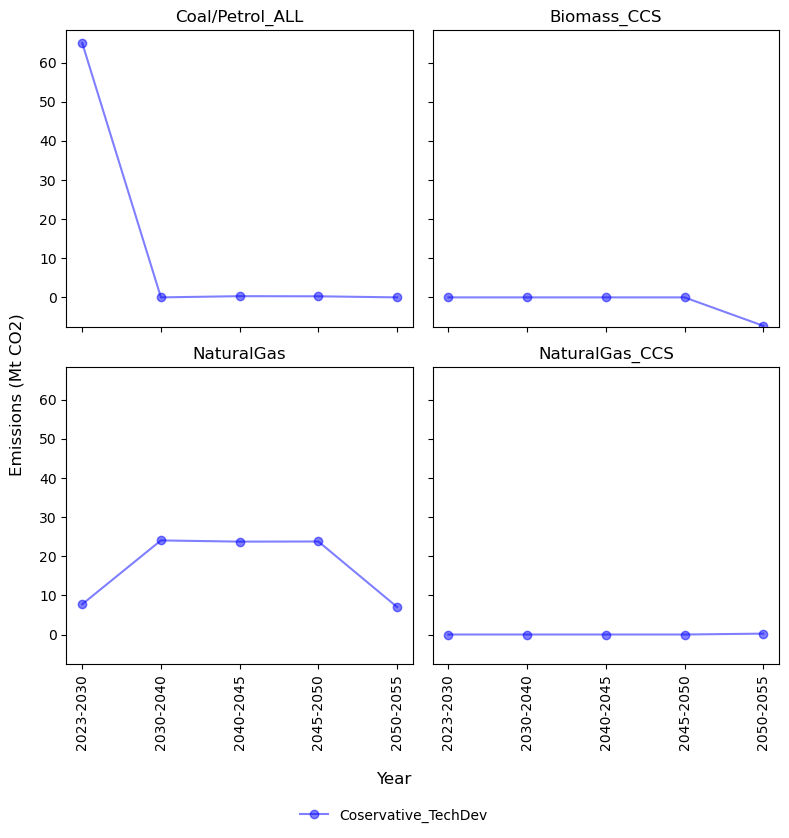

In [37]:
Iten="Activity" # "Activity" or "Emissions" or "Capacity"
PlotGroups=[]
PlotGroups.append(["Coal/Petrol_ALL","NaturalGas", "NaturalGas_CCS"])#Line 1
PlotGroups.append(["Wind_ON/OFF","Biomass","Biomass_CCS"])#Line 2
PlotGroups.append(["Solar","Nuclear", "Wind_OFF"])#Line 3 # Hydro
Plot(Iten,PlotGroups)

################################
Iten="Capacity" # "Activity" or "Emissions" or "Capacity"
PlotGroups=[]
PlotGroups.append(["Coal/Petrol_ALL","NaturalGas", "NaturalGas_CCS"])#Line 1
PlotGroups.append(["Wind_ON/OFF","Biomass","Biomass_CCS"])#Line 2
PlotGroups.append(["Solar","Nuclear", "Wind_OFF"])#Line 3
Plot(Iten,PlotGroups)

################################
Iten="Emissions" # "Activity" or "Emissions" or "Capacity"
PlotGroups=[]
PlotGroups.append(["Coal/Petrol_ALL","Biomass_CCS"])#Line 1
PlotGroups.append(["NaturalGas","NaturalGas_CCS"])#Line 2

Plot(Iten,PlotGroups)

# Plot the results per hour